### Importing Libraries

In [573]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import re

pd.options.mode.chained_assignment = None 

### Poverty, Education for Each State from 1991-2019

In [373]:
### poverty ###

# poverty by state from 2019 - 1991
pov = pd.read_csv("hstpov21.csv")
pov = pov.dropna(axis = 0)

In [374]:
# every time first col has "STATE", that's a new df
    # new df every 52 rows
    
s = len(pov)/52 # number of splits we want
pov_dfs = np.array_split(pov, s)

# dictionary for pov_dfs
pov_dict = {}
col_names = ["State", "Total Poor", "Below Poverty", "Standard Error", "Percent", "Standard Error"]
num = 2019
for df in pov_dfs:
    df_new = df[1:]
    df_new.columns = col_names
    pov_dict[str(num)] = df_new
    num -= 1

In [375]:
# 1991 - 2019 #
edu_d = {}
for i in range(1991, 2020):
    if i in [1992, 2007, 2008, 2009]: # years we don't have
        continue
    s = str(i) + ".csv"
    df = pd.read_csv(s)
    (sts, hs_over, bach_over) = (df.iloc[:, 0], df.iloc[:, 1], df.iloc[:, 2])
    data = {"Percent high school and over":hs_over, "Percent bachelor's and over":bach_over}
    d = pd.DataFrame(data)
    d.index = sts
    edu_d[str(i)] = d

In [376]:
# edu_d is our education dict, pov_dict is our poverty dict
# [["Alabama", 1991], ["Alabama", 1992], etc]
years = [x for x in range(1991, 2020)]

sy = []
for state in sts:
    for year in years:
        sy.append([state, year])
        
c = pd.DataFrame(sy)

for newcol in ["Total poor", "Below poverty", "Percent of poor below poverty", 
             "Percent HS or higher", "Percent Bach or higher"]:
    c[newcol] = np.nan

c.rename(columns = {0:"State", 1:"Year"}, inplace = True)

# iterate over pov_dict and add values
for year in pov_dict:
    for index, row in pov_dict[year].iterrows():
        (tp, bp, per) = (row["Total Poor"], row["Below Poverty"], row["Percent"])
        c.loc[(c["State"] == row["State"]) & (c["Year"] == int(year)), ["Total poor"]] = tp
        c.loc[(c["State"] == row["State"]) & (c["Year"] == int(year)), ["Below poverty"]] = bp
        c.loc[(c["State"] == row["State"]) & (c["Year"] == int(year)), ["Percent of poor below poverty"]] = per

In [377]:
# do the same for education
for year in edu_d:
    for index, row in edu_d[year].iterrows():
        (hs, bach) = row.values
        c.loc[(c["State"] == row.name) & (c["Year"] == int(year)), ["Percent HS or higher"]] = hs
        c.loc[(c["State"] == row.name) & (c["Year"] == int(year)), ["Percent Bach or higher"]] = bach

In [378]:
#c.to_csv("combined.csv")

### Poor Density vs. Hate Crime Density

In [463]:
merged = pd.read_csv("merged.csv")

In [464]:
merged.set_index(['State_Abbr','State','Year'], inplace=True)
merged = merged[['num_crimes','num_asians_per_km2']]
merged['density'] = merged['num_crimes']/merged['num_asians_per_km2']

In [465]:
merged = merged.drop(["num_crimes", "num_asians_per_km2"], axis = 1)

In [474]:
merged

density
State_Abbr State      Year           
CA         California 1997  10.666667
                      1996  10.200000
                      1995   9.466667
                      1998   9.000000
                      1999   8.400000
...                               ...
MT         Montana    1997   0.000000
                      1998   0.000000
                      2001   0.000000
                      2002   0.000000
WY         Wyoming    2019   0.000000

[1479 rows x 1 columns]

In [475]:
# get poor densities - total below poverty line / state pop
    # add state population to c
age = pd.read_csv("Age.csv")

In [476]:
age_groups = age.groupby(["State", "Year"])["Population"].sum().reset_index()
c["Population"] = 0
c["Poor density"] = 0

age_groups

,State,Year,Population
0,Alabama,1991,4099156
1,Alabama,1992,4154014
2,Alabama,1993,4214202
3,Alabama,1994,4260229
4,Alabama,1995,4296800
...,...,...,...
1474,Wyoming,2015,585613
1475,Wyoming,2016,584215
1476,Wyoming,2017,578931
1477,Wyoming,2018,577601


In [477]:
for index, row in age_groups.iterrows():
    c.loc[(c["State"] == row["State"]) & (c["Year"] == int(row["Year"])), ["Population"]] = row["Population"]

In [478]:
c = c.replace(',','', regex=True)
bp = c["Below poverty"].astype(int)
p = c["Population"].astype(int)

c["Poor density"] = ((bp/p)*100).to_frame()

In [479]:
# add density from merged to c
c["Population density"] = np.nan

for index, row in merged.iterrows():
    c.loc[(c["State"] == row.name[1]) & (c["Year"] == row.name[2]), ["Population density"]] = row.values[0]

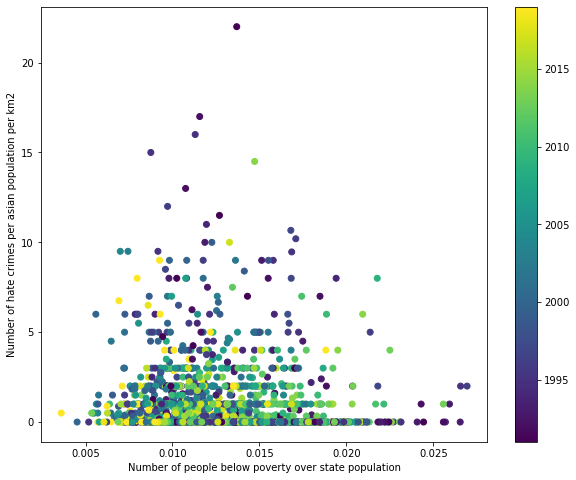

In [484]:
plt.figure(figsize = (10, 8))
plt.scatter(c["Poor density"], c["Population density"], c = c["Year"])

plt.ylabel('Number of hate crimes per asian population per km2')
plt.xlabel('Number of people below poverty over state population')
plt.colorbar()
plt.show()

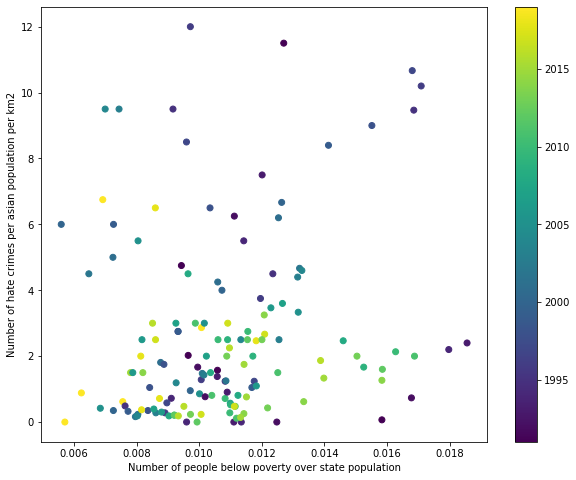

,State,Year,Total poor,Below poverty,Percent of poor below poverty,Percent HS or higher,Percent Bach or higher,Population,Poor density,Population density
116,California,1991,30735,4825,15.7,77.8,24.2,30470736,0.015835,0.066667
117,California,1992,31701,5197,16.4,NaN,NaN,30974659,0.016778,0.733333
118,California,1993,31970,5803,18.2,79.7,25.0,31274928,0.018555,2.400000
119,California,1994,31669,5658,17.9,79.1,24.7,31484435,0.017971,2.200000
120,California,1995,32055,5342,16.7,79.6,24.2,31696582,0.016854,9.466667
...,...,...,...,...,...,...,...,...,...,...
1387,Washington,2015,7193,819,11.4,90.8,34.2,7163657,0.011433,1.750000
1388,Washington,2016,7289,800,11,90.8,35.1,7294771,0.010967,2.250000
1389,Washington,2017,7425,810,10.9,91.3,35.5,7423362,0.010911,3.000000
1390,Washington,2018,7555,647,8.6,91.6,36.7,7523869,0.008599,6.500000


In [489]:
# do for top and bottom five states
top_five = ["New Jersey", "Massachusetts", "Washington", "Minnesota", "California"]
bot_five = ["South Dakota", "Alabama", "Louisiana", "North Dakota"]
top, bot = c[c.State.isin(top_five)], c[c.State.isin(bot_five)]

plt.figure(figsize = (10, 8))
plt.scatter(top["Poor density"], top["Population density"], c = top["Year"])

plt.ylabel('Number of hate crimes per asian population per km2')
plt.xlabel('Number of people below poverty over state population')
plt.show()

Text(0, 0.5, 'Asian population density')

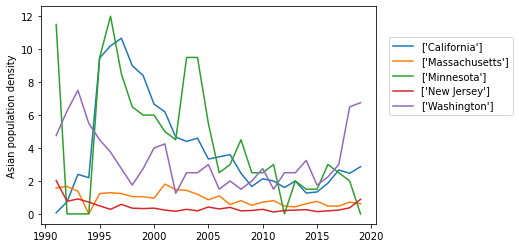

In [498]:
# for top five: asian population density and poor density over time
for name, group in top.groupby("State"):
    plt.plot(group["Year"], group["Population density"], label = group["State"].unique())
plt.legend(loc = (1.04, 0.5))
plt.ylabel("Asian population density")

Text(0, 0.5, 'Poor population density')

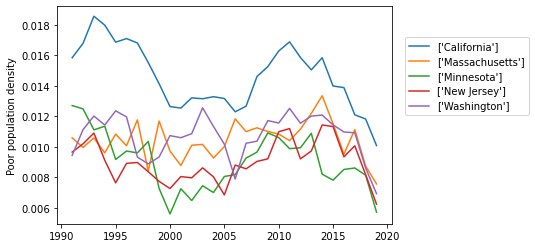

In [497]:
# poor density
for name, group in top.groupby("State"):
    plt.plot(group["Year"], group["Poor density"], label = group["State"].unique())
plt.legend(loc = (1.04, 0.5))
plt.ylabel("Poor population density")

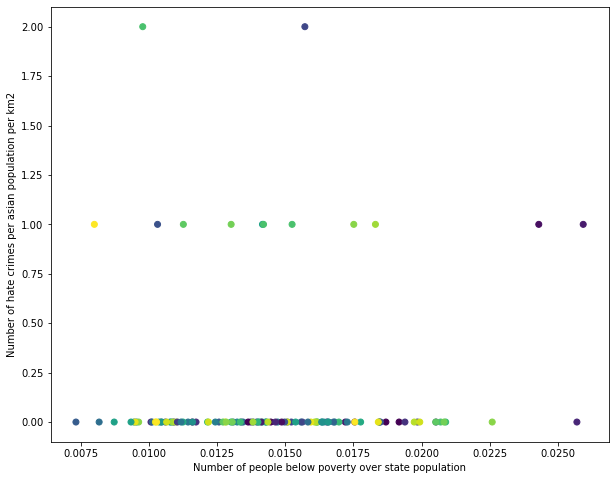

In [490]:
# bottom five states
plt.figure(figsize = (10, 8))
plt.scatter(bot["Poor density"], bot["Population density"], c = bot["Year"])

plt.ylabel('Number of hate crimes per asian population per km2')
plt.xlabel('Number of people below poverty over state population')
plt.show()

Text(0, 0.5, 'Asian population density')

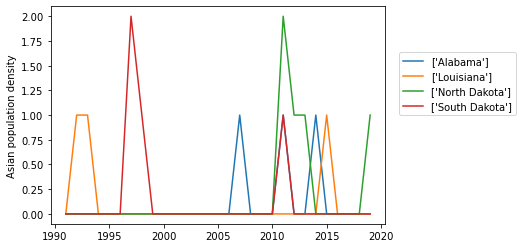

In [499]:
# for bottom five: asian population density and poor density over time
for name, group in bot.groupby("State"):
    plt.plot(group["Year"], group["Population density"], label = group["State"].unique())
plt.legend(loc = (1.04, 0.5))
plt.ylabel("Asian population density")

Text(0, 0.5, 'Poor population density')

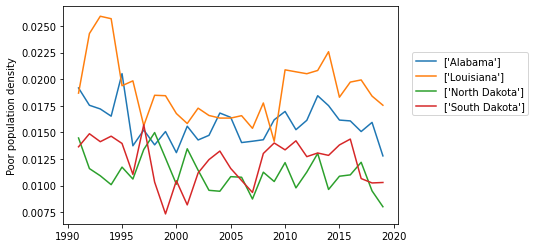

In [500]:
for name, group in bot.groupby("State"):
    plt.plot(group["Year"], group["Poor density"], label = group["State"].unique())
plt.legend(loc = (1.04, 0.5))
plt.ylabel("Poor population density")

### More Top Five, Bottom Five Time Series

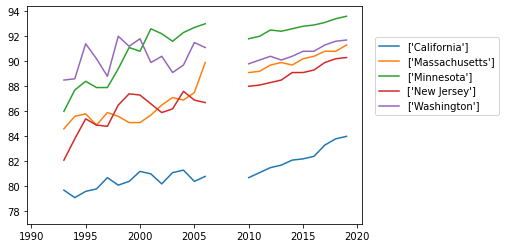

In [389]:
# education #

# percent hs or higher
    # top 5
for name, group in top.groupby("State"):
    plt.plot(group["Year"], group["Percent HS or higher"], label = group["State"].unique())
plt.legend(loc = (1.04, 0.5))

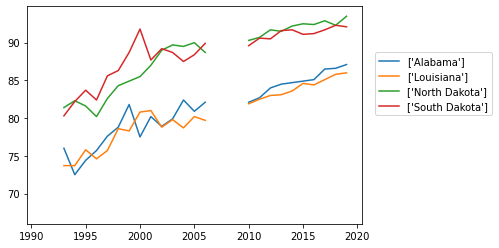

In [390]:
# percent hs or higher
    # bot 5
for name, group in bot.groupby("State"):
    plt.plot(group["Year"], group["Percent HS or higher"], label = group["State"].unique())
plt.legend(loc = (1.04, 0.5))

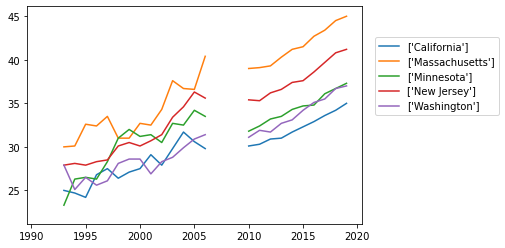

In [391]:
# percent bach or higher
    # top 5
for name, group in top.groupby("State"):
    plt.plot(group["Year"], group["Percent Bach or higher"], label = group["State"].unique())
plt.legend(loc = (1.04, 0.5))

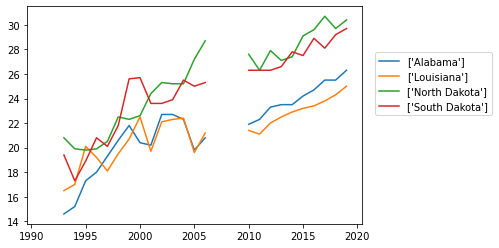

In [392]:
# percent bach or higher
    # bot 5
for name, group in bot.groupby("State"):
    plt.plot(group["Year"], group["Percent Bach or higher"], label = group["State"].unique())
plt.legend(loc = (1.04, 0.5))

## Offense Type for Hate Crime

In [576]:
hate = pd.read_csv("hate_crime.csv", low_memory = True)

C:\Users\sophi\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [608]:
antia = hate[hate["BIAS_DESC"] == "Anti-Asian"]
crimes = list(antia.groupby("OFFENSE_NAME").groups.keys())

to_shorten = ["Aggravated Assault", "Destruction/Damage/Vandalism of Property",
             "Intimidation", "Burglary/Breaking & Entering", "Theft", "Shoplifting",
             "Robbery", "Not Specified", "All Other Larceny", "Arson"]

for w in to_shorten:
    s = w + ".+"
    crimes = [re.sub(s, w, word) for word in crimes]

crimes = list(set(crimes))

['Burglary/Breaking & Entering',
 'Fondling',
 'Drug/Narcotic Violations',
 'Counterfeiting/Forgery',
 'Shoplifting',
 'Rape',
 'Destruction/Damage/Vandalism of Property',
 'Stolen Property Offenses',
 'Simple Assault',
 'All Other Larceny',
 'Intimidation',
 'Kidnapping/Abduction',
 'Not Specified',
 'Arson',
 'Motor Vehicle Theft',
 'Aggravated Assault',
 'Robbery',
 'Embezzlement',
 'Prostitution',
 'Pornography/Obscene Material',
 'Murder and Nonnegligent Manslaughter',
 'False Pretenses/Swindle/Confidence Game',
 'Theft',
 'Credit Card/Automated Teller Machine Fraud',
 'Drug Equipment Violations',
 'Purchasing Prostitution',
 'Impersonation',
 'Weapon Law Violations']

In [609]:
i = 0
for index, row in antia.iterrows():
    for word in crimes:
        if word in row["OFFENSE_NAME"]:
            antia.iloc[i, 21] = word
    i += 1


# antia["OFFENSE_NAME"] = antia["OFFENSE_NAME"].apply(lambda x: x.replace(x, str([y for y in crimes if x in y][0])))
            
antia["OFFENSE_NAME"].unique()    

array(['Intimidation', 'Aggravated Assault',
       'Destruction/Damage/Vandalism of Property', 'Simple Assault',
       'Robbery', 'Not Specified', 'Burglary/Breaking & Entering',
       'Arson', 'Rape', 'Murder and Nonnegligent Manslaughter', 'Theft',
       'All Other Larceny', 'Shoplifting', 'Weapon Law Violations',
       'Counterfeiting/Forgery', 'Drug/Narcotic Violations',
       'False Pretenses/Swindle/Confidence Game', 'Prostitution',
       'Pornography/Obscene Material', 'Embezzlement', 'Impersonation',
       'Stolen Property Offenses', 'Fondling', 'Kidnapping/Abduction',
       'Drug Equipment Violations', 'Purchasing Prostitution',
       'Credit Card/Automated Teller Machine Fraud'], dtype=object)

In [611]:
# group by offense name and year
offs = antia.groupby(["OFFENSE_NAME", "DATA_YEAR"]).size().reset_index()
offs.columns = ["offense", "year", "num"]

offs

,offense,year,num
0,Aggravated Assault,1991,29
1,Aggravated Assault,1992,20
2,Aggravated Assault,1993,35
3,Aggravated Assault,1994,18
4,Aggravated Assault,1995,36
...,...,...,...
302,Weapon Law Violations,2001,2
303,Weapon Law Violations,2005,1
304,Weapon Law Violations,2006,1
305,Weapon Law Violations,2016,2


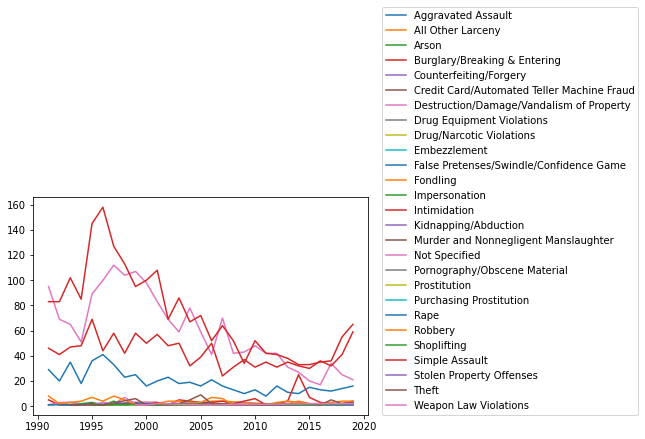

In [619]:
for name, group in offs.groupby("offense"):
    plt.plot(group["year"], group["num"], label = name)
plt.legend(loc = (1.04, 0.0))

In [659]:
# top 5 offense types
o = offs.groupby("offense").size().reset_index()
o.columns = ["offense", "num"]
o = o.sort_values("num", ascending = False).iloc[:5, :]
o_use = list(o["offense"])

o_use

['Aggravated Assault',
 'Destruction/Damage/Vandalism of Property',
 'Simple Assault',
 'Intimidation',
 'Burglary/Breaking & Entering']

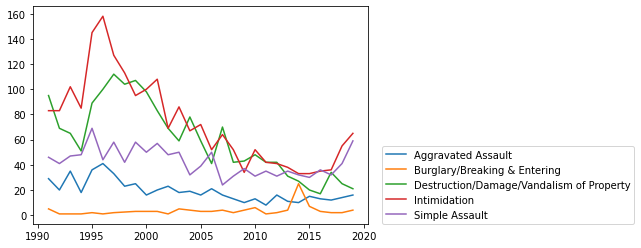

In [662]:
offs5 = offs[offs["offense"].isin(o_use)]

for name, group in offs5.groupby("offense"):
    plt.plot(group["year"], group["num"], label = name)
plt.legend(loc = (1.04, 0.0))

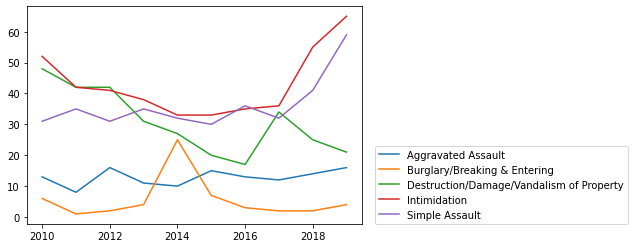

In [665]:
# look at last ten years - spikes in intimidation, simple assault
offs_zoom = offs5[offs5["year"] > 2009]

for name, group in offs_zoom.groupby("offense"):
    plt.plot(group["year"], group["num"], label = name)
plt.legend(loc = (1.04, 0.0))